In [1]:
import time
import random
import numpy as np
import pandas as pd
import argparse
import torch
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torch import nn

from models import BatteryGPT, TimeLLM, BatteryGPT_mask, Autoformer, DLinear
from data_provider.data_factory import data_provider


filetime = time.strftime('%Y%m%d%H%M', time.localtime())
parser = argparse.ArgumentParser(description='Time-LLM')

# basic config
parser.add_argument('--task_name', type=str, required=False, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser.add_argument('--model_id', type=str, required=False, default='Battery', help='model id')
parser.add_argument('--model_comment', type=str, required=False, default='none', help='prefix when saving test results')
parser.add_argument('--seed', type=int, default=42, help='random seed')

# data loader
parser.add_argument('--root_path', type=str, default='./dataset/my', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='trimmed_LX3_ss0_se100_cr05_C_V_T_vs_CE.csv', help='data file')
parser.add_argument('--drop_bid', type=int, default=0)
parser.add_argument('--scale_data', type=int, default=1,  help='do dataset scaleing?')
parser.add_argument('--cal_mask', type=int, default=1,  help='cal y mask?')
parser.add_argument('--cutting_rate', type=float, default=0.2)

parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; '
                            'M:multivariate predict multivariate, S: univariate predict univariate, '
                            'MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--loader', type=str, default='modal', help='dataset type')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, '
                            'options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], '
                            'you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./cache/', help='location of model checkpoints')
parser.add_argument('--logger', type=str, default='./logs', help='log folder')
parser.add_argument('--on_server', type=bool, default=False)

# forecasting task
parser.add_argument('--seq_limit', type=int, default=48, help='raw sequence length')
parser.add_argument('--seq_len', type=int, default=18, help='input sequence length')
parser.add_argument('--label_len', type=int, default=9, help='start token length')
parser.add_argument('--pred_len', type=int, default=30, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')

# model define
parser.add_argument('--enc_in', type=int, default=11, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=1, help='output size')
parser.add_argument('--d_model', type=int, default=16, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=32, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--patch_len', type=int, default=8, help='patch length')
parser.add_argument('--stride', type=int, default=4, help='stride')
parser.add_argument('--prompt_domain', type=int, default=0, help='')

# optimization
parser.add_argument('--num_workers', type=int, default=1, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--align_epochs', type=int, default=10, help='alignment epochs')
parser.add_argument('--batch_size', type=int, default=8, help='batch size of train input data')
parser.add_argument('--eval_batch_size', type=int, default=8, help='batch size of model evaluation')
parser.add_argument('--patience', type=int, default=10, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--pct_start', type=float, default=0.2, help='pct_start')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--llm_layers', type=int, default=6)
parser.add_argument('--percent', type=int, default=100)

args = parser.parse_args(args=[])


fix_seed = args.seed
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)


accelerator = Accelerator(mixed_precision='bf16', device_placement=False)





### 202403142139

In [ ]:
sd_202403142139 = r'./cache\long_term_forecast_Battery_BatteryGPT_masked_battery_ftM_sl18_ll9_pl30_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-BatteryGPT-Masked_battery\checkpoint'
args.model = 'TimeLLM'
args.data = 'batdata'
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1
args.batch_size = 1

### 202403151801

In [2]:
sd = r'cache\long_term_forecast_Battery_BatteryGPT_masked_battery_ftM_sl18_ll9_pl30_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-BatteryGPT-Masked_battery\202403151801_checkpoint'
args.data = 'batdata'
args.seq_len=18
args.label_len=9
args.pred_len=30
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1
args.batch_size = 1
args.scale_data=1         # 不归一化
args.cal_mask=0           # mask数据应该计算掩码损失

# 读取模型
model = BatteryGPT.Model(args).float()
model.load_state_dict(torch.load(sd))

# 模型参数量
cnts = 0
for param in model.parameters():
    cnts += param.numel()
cnts

# 读取数据
test_data, test_loader = data_provider(args, 'test')

# 启动accelerator
test_loader, model = accelerator.prepare(
    test_loader, model)

data-2 load completed: (27471,) lunci


In [3]:
def test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark):
    """验证一次模型"""
    batch_x = batch_x.float().to(accelerator.device)
    batch_y = batch_y.float().to(accelerator.device)
    batch_x_mark = batch_x_mark.float().to(accelerator.device)
    batch_y_mark = batch_y_mark.float().to(accelerator.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()

    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0

    # batch_y = batch_y * batch_y_mark
    # outputs = outputs * batch_y_mark[:, -args.pred_len:, :]

    pred = outputs[:, -args.pred_len:, f_dim:].detach().cpu().numpy()
    true = batch_y[:, -args.pred_len:, f_dim:].detach().cpu().numpy()

    train_y = batch_x[:, :args.seq_len, -1].detach().cpu().numpy()

    # loss = criterion(pred, true)
    # mae_loss = mae_metric(pred, true)

    return pred, true, train_y


def concat_yyhat(y, yhat, train_ys, save=False, show_index:tuple=(0,0)):
    """合并y、yhat"""
    y1 = np.array(y).squeeze()
    yhat1 = np.array(yhat).squeeze()
    train_y1 = np.array(train_ys)

    print('y:', y1.shape, 'yhat:', yhat1.shape, 'train_y', train_y1.shape)

    y1 = np.array(y).squeeze(-1)
    yhat1 = np.array(yhat).squeeze(-1)
    y1 = np.concatenate([train_y1, y1], axis=-1)
    yhat1 = np.concatenate([train_y1, yhat1], axis=-1)
    # print(y1.shape)
    # print(yhat1.shape)

    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in y1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df1 = pd.DataFrame(y1.reshape(-1), index=index, columns=['y'])
    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in yhat1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df2 = pd.DataFrame(yhat1.reshape(-1), index=index, columns=['yhat'])

    df = pd.concat([df1, df2], axis=1)

    if save:
        df.to_csv('./ana_model_pred.csv')

    if show_index:
        df.loc[show_index, ['y', 'yhat']].plot()

    return df


def show(df, show_index:tuple=(0,0)):
    df.loc[show_index, ['y', 'yhat']].plot()


model.to(accelerator.device)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()
model.eval()

y = []
yhat = []
train_ys = []
vali_ys = []
loader = iter(test_loader)
i = 0

In [4]:
while i < len(test_loader):
    print('batch: %d' %i)
    # 验证模型
    batch_x, batch_y, batch_x_mark, batch_y_mark = next(loader)
    pred, true, train_y = test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark)
    # print(pred.shape, true.shape)

    yhat.append(pred)
    y.append(true)
    train_ys.append(train_y)
    # vali_ys.append(vali_y)

    # print(len(yhat), len(y))
    i += 1


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

y: (5, 30) yhat: (5, 30) train_y (5, 1, 18)


y      yhat
batch seq id                    
0     0   0  -1.038813 -1.038813
          1  -1.014391 -1.014391
          2  -0.989970 -0.989970
          3  -0.964721 -0.964721
          4  -0.939886 -0.939886
...                ...       ...
4     0   43  0.211642  0.128906
          44  0.218679  0.146484
          45  0.227371  0.161133
          46  0.228613  0.175781
          47  0.228613  0.187500

[240 rows x 2 columns]

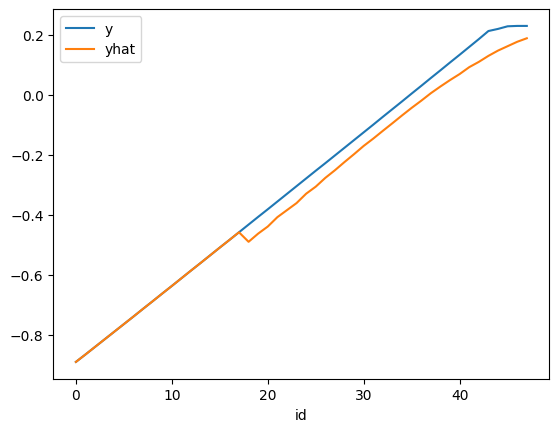

In [44]:
df = concat_yyhat(y, yhat, train_ys, show_index=(4,0))
display(df)

y: (10, 1, 30, 1) yhat: (10, 1, 30, 1)


y      yhat
batch seq id                    
0     0   0  -0.434156 -0.474609
          1  -0.408492 -0.449219
          2  -0.382828 -0.425781
          3  -0.357577 -0.394531
          4  -0.331913 -0.373047
...                ...       ...
9     0   25  0.300587  0.157227
          26  0.311764  0.170898
          27  0.316731  0.180664
          28  0.319628  0.193359
          29  0.320042  0.202148

[300 rows x 2 columns]

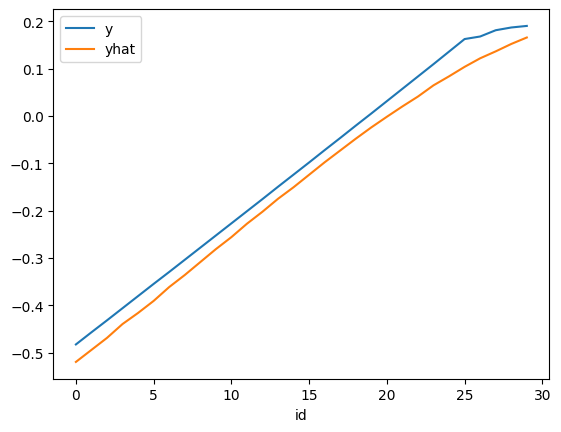

In [82]:
df = concat_yyhat(y, yhat, show_index=(5,0))
display(df)

### 202403161253

In [2]:
sd = r'cache\base_mask_BatteryGPTv1_mbatdata_ftM_sl24_ll12_pl36_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-on_server\202403161253_checkpoint'
args.data = 'mbatdata'
args.seq_len=24
args.label_len=12
args.pred_len=36
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1
args.batch_size = 1


# 读取模型
model = BatteryGPT_mask.Model(args).float()
model.load_state_dict(torch.load(sd))

# 读取数据
test_data, test_loader = data_provider(args, 'test')

# 启动accelerator
test_loader, model = accelerator.prepare(
    test_loader, model)

# 模型参数量
cnts = 0
for param in model.parameters():
    cnts += param.numel()
cnts

data-2 load completed: (27471,)


In [4]:
def test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark):
    """验证一次模型"""
    batch_x = batch_x.float().to(accelerator.device)
    batch_y = batch_y.float().to(accelerator.device)
    batch_x_mark = batch_x_mark.float().to(accelerator.device)
    batch_y_mark = batch_y_mark.float().to(accelerator.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()

    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs = outputs[:, -args.pred_len:, f_dim:]
    batch_y = batch_y[:, -args.pred_len:, f_dim:]

    pred = outputs.detach().cpu().numpy()
    true = batch_y.detach().cpu().numpy()

    # loss = criterion(pred, true)
    # mae_loss = mae_metric(pred, true)

    return pred, true


def concat_yyhat(y, yhat, save=False, show_index:tuple=(0,0)):
    """合并y、yhat"""
    y1 = np.array(y)
    yhat1 = np.array(yhat)

    print('y:', y1.shape, 'yhat:', yhat1.shape)

    y1 = np.array(y).squeeze(-1)
    yhat1 = np.array(yhat).squeeze(-1)

    # print(y1.shape)
    # print(yhat1.shape)

    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in y1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df1 = pd.DataFrame(y1.reshape(-1), index=index, columns=['y'])
    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in yhat1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df2 = pd.DataFrame(yhat1.reshape(-1), index=index, columns=['yhat'])

    df = pd.concat([df1, df2], axis=1)

    if save:
        df.to_csv('./ana_model_pred.csv')

    if show_index:
        df.loc[show_index, ['y', 'yhat']].plot()

    return df


def show(df, show_index:tuple=(0,0)):
    df.loc[show_index, ['y', 'yhat']].plot()


model.to(accelerator.device)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()
model.eval()

y = []
yhat = []
loader = iter(test_loader)

In [11]:
# 验证模型
batch_x, batch_y, batch_x_mark, batch_y_mark = next(loader)
pred, true = test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark)
print(pred.shape, true.shape)

yhat.append(pred)
y.append(true)
print(len(yhat), len(y))

(1, 36, 1) (1, 36, 1)
7 7


y: (7, 1, 36, 1) yhat: (7, 1, 36, 1)


y      yhat
batch seq id                    
0     0   0   0.268028  0.263672
          1   0.270092  0.271484
          2   0.270092  0.277344
          3   0.000000  0.267578
          4   0.000000  0.287109
...                ...       ...
6     0   31  0.182562  0.173828
          32  0.209399  0.191406
          33  0.215592  0.208008
          34  0.228392  0.223633
          35  0.234172  0.231445

[252 rows x 2 columns]

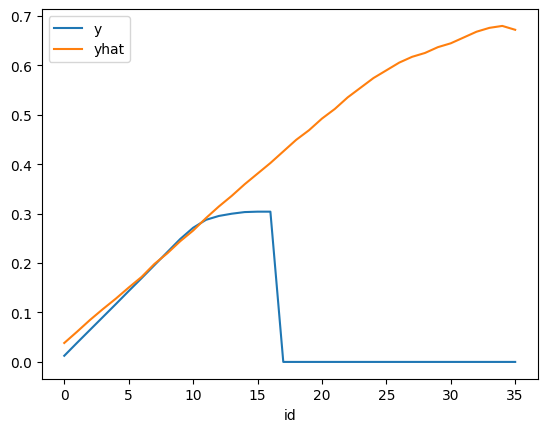

In [16]:
df = concat_yyhat(y, yhat, show_index=(0,0))
display(df)

### 202403171514

In [47]:
sd = r'cache\base_mask_from0_BatteryGPTv0_batdata_from_0_ftM_sl24_ll12_pl48_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-on_server\202403171514_checkpoint'
args.data = 'batdata_from_0'
args.model='BatteryGPTv0'
args.seq_len=24
args.label_len=12
args.pred_len=48
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1
args.batch_size = 1
args.scale_data=0         # 不归一化
args.cal_mask=1           # mask数据应该计算掩码损失


# 读取模型
if args.model == 'Autoformer':
    model = Autoformer.Model(args).bfloat16()
elif args.model == 'DLinear':
    model = DLinear.Model(args).bfloat16()
elif args.model == 'BatteryGPTv0':
    model = BatteryGPT.Model(args).bfloat16()
elif args.model == 'BatteryGPTv1':
    model = BatteryGPT_mask.Model(args).bfloat16()
else:
    model = TimeLLM.Model(args).bfloat16()
model.load_state_dict(torch.load(sd))


# 读取数据
test_data, test_loader = data_provider(args, 'test')

# 启动accelerator
test_loader, model = accelerator.prepare(
    test_loader, model)

# 模型参数量
cnts = 0
for param in model.parameters():
    cnts += param.numel()
cnts

data-2 load completed: (27471,) from 0


318889068

In [48]:
def test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark):
    """验证一次模型"""
    batch_x = batch_x.float().to(accelerator.device)
    batch_y = batch_y.float().to(accelerator.device)
    batch_x_mark = batch_x_mark.float().to(accelerator.device)
    batch_y_mark = batch_y_mark.float().to(accelerator.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()

    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs = outputs[:, -args.pred_len:, f_dim:]
    batch_y = batch_y[:, -args.pred_len:, f_dim:]

    pred = outputs.detach().cpu().numpy()
    true = batch_y.detach().cpu().numpy()

    # loss = criterion(pred, true)
    # mae_loss = mae_metric(pred, true)

    return pred, true


def concat_yyhat(y, yhat, save=False, show_index:tuple=(0,0)):
    """合并y、yhat"""
    y1 = np.array(y)
    yhat1 = np.array(yhat)

    print('y:', y1.shape, 'yhat:', yhat1.shape)

    y1 = np.array(y).squeeze(-1)
    yhat1 = np.array(yhat).squeeze(-1)

    # print(y1.shape)
    # print(yhat1.shape)

    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in y1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df1 = pd.DataFrame(y1.reshape(-1), index=index, columns=['y'])
    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in yhat1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df2 = pd.DataFrame(yhat1.reshape(-1), index=index, columns=['yhat'])

    df = pd.concat([df1, df2], axis=1)

    if save:
        df.to_csv('./ana_model_pred.csv')

    if show_index:
        df.loc[show_index, ['y', 'yhat']].plot()

    return df


def show(df, show_index:tuple=(0,0)):
    df.loc[show_index, ['y', 'yhat']].plot()


model.to(accelerator.device)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()
model.eval()

y = []
yhat = []
loader = iter(test_loader)

In [55]:
# 验证模型
batch_x, batch_y, batch_x_mark, batch_y_mark = next(loader)
pred, true = test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark)
print(pred.shape, true.shape)

yhat.append(pred)
y.append(true)
print(len(yhat), len(y))

(1, 48, 1) (1, 48, 1)
7 7


y: (7, 1, 48, 1) yhat: (7, 1, 48, 1)


y     yhat
batch seq id                 
0     0   0   1499.0   1488.0
          1   1561.0   1536.0
          2   1622.0   1576.0
          3   1684.0   1640.0
          4   1745.0   1664.0
...              ...      ...
6     0   43     0.0  10240.0
          44     0.0  11072.0
          45     0.0  12352.0
          46     0.0   9792.0
          47     0.0   6688.0

[336 rows x 2 columns]

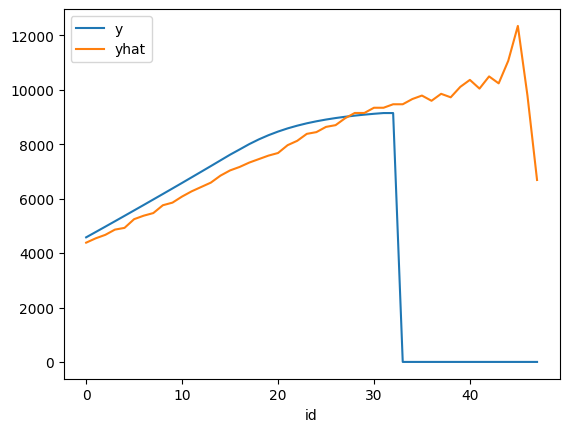

In [58]:
df = concat_yyhat(y, yhat, show_index=(6,0))
display(df)

### 202403181159

In [36]:
sd = r'cache\base_unmasked_BatteryGPTv0_batdata_ftM_sl18_ll9_pl30_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-on_server\202403181159_checkpoint'
args.data = 'batdata'
args.model='BatteryGPTv0'
args.seq_len=18
args.label_len=9
args.pred_len=30
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1
args.batch_size = 1
args.scale_data=0         # 不归一化
args.cal_mask=0           # mask数据应该计算掩码损失


# 读取模型
if args.model == 'Autoformer':
    model = Autoformer.Model(args).bfloat16()
elif args.model == 'DLinear':
    model = DLinear.Model(args).bfloat16()
elif args.model == 'BatteryGPTv0':
    model = BatteryGPT.Model(args).bfloat16()
elif args.model == 'BatteryGPTv1':
    model = BatteryGPT_mask.Model(args).bfloat16()
else:
    model = TimeLLM.Model(args).bfloat16()
model.load_state_dict(torch.load(sd))


# 读取数据
test_data, test_loader = data_provider(args, 'test')

# 启动accelerator
test_loader, model = accelerator.prepare(
    test_loader, model)

# 模型参数量
cnts = 0
for param in model.parameters():
    cnts += param.numel()
cnts

data-2 load completed: (27471,) lunci


318867546

In [37]:
def test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark):
    """验证一次模型"""
    batch_x = batch_x.float().to(accelerator.device)
    batch_y = batch_y.float().to(accelerator.device)
    batch_x_mark = batch_x_mark.float().to(accelerator.device)
    batch_y_mark = batch_y_mark.float().to(accelerator.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()

    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs = outputs[:, -args.pred_len:, f_dim:]
    batch_y = batch_y[:, -args.pred_len:, f_dim:]

    pred = outputs.detach().cpu().numpy()
    true = batch_y.detach().cpu().numpy()

    # loss = criterion(pred, true)
    # mae_loss = mae_metric(pred, true)

    return pred, true


def concat_yyhat(y, yhat, save=False, show_index:tuple=(0,0)):
    """合并y、yhat"""
    y1 = np.array(y)
    yhat1 = np.array(yhat)

    print('y:', y1.shape, 'yhat:', yhat1.shape)

    y1 = np.array(y).squeeze(-1)
    yhat1 = np.array(yhat).squeeze(-1)

    # print(y1.shape)
    # print(yhat1.shape)

    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in y1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df1 = pd.DataFrame(y1.reshape(-1), index=index, columns=['y'])
    # 将前两个维度作为 MultiIndex
    index = pd.MultiIndex.from_product([range(s) for s in yhat1.shape[:3]], names=['batch', 'seq', 'id'])
    # 将数组转换为 DataFrame
    df2 = pd.DataFrame(yhat1.reshape(-1), index=index, columns=['yhat'])

    df = pd.concat([df1, df2], axis=1)

    if save:
        df.to_csv('./ana_model_pred.csv')

    if show_index:
        df.loc[show_index, ['y', 'yhat']].plot()

    return df


def show(df, show_index:tuple=(0,0)):
    df.loc[show_index, ['y', 'yhat']].plot()


model.to(accelerator.device)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()
model.eval()

y = []
yhat = []
loader = iter(test_loader)

In [45]:
# 验证模型
batch_x, batch_y, batch_x_mark, batch_y_mark = next(loader)
pred, true = test_one_cycle(model, batch_x, batch_y, batch_x_mark, batch_y_mark)
print(pred.shape, true.shape)

yhat.append(pred)
y.append(true)
print(len(yhat), len(y))

(1, 30, 1) (1, 30, 1)
8 8


y: (8, 1, 30, 1) yhat: (8, 1, 30, 1)


y    yhat
batch seq id                
0     0   0   3603.0  4192.0
          1   3794.0  4352.0
          2   3986.0  4512.0
          3   4179.0  4736.0
          4   4373.0  4896.0
...              ...     ...
7     0   25  3231.0  3088.0
          26  3279.0  3168.0
          27  3310.0  3184.0
          28  3324.0  3232.0
          29  3333.0  3264.0

[240 rows x 2 columns]

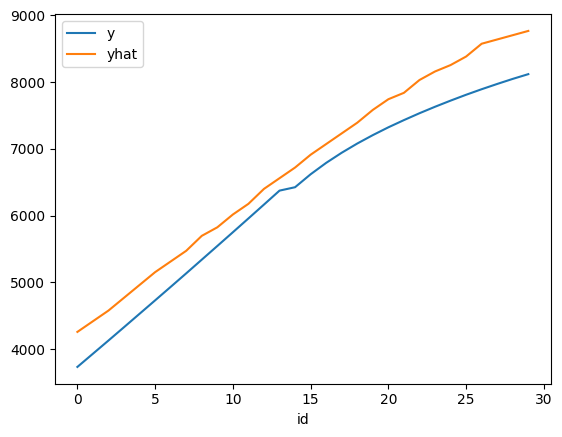

In [48]:
df = concat_yyhat(y, yhat, show_index=(1,0))
display(df)